# Training the Hybrid Classifier

This notebook sets up the training pipeline for detecting whether an image was created by a human or an AI model using a Hybrid Classifier. <br>

### Why a Hybrid Classifier?
We noticed that when humans look at AI-generated images, we can often tell they’re fake because of:
- Weird brightness (too bright or too dull)
- Unusual contrast (shadows or colors look off)
- Overly sharp or unnatural edges
- Strong or strange colors that don’t look real

<br>

### What the Hybrid Classifier Does?
To make use of these clues, we built a hybrid model that combines:
1. CNN + Attention Branch:
    - Learns useful patterns in the image (like textures, shapes, and areas to focus on).
    - Uses spatial attention to find the most important parts of the image.
2. Handcrafted Feature Branch:
    - Manually calculates simple but powerful image stats like:
        - Brightness (how light the image is)
        - Contrast (how different the light and dark areas are)
        - Edge strength (how sharp or defined the lines are)
    - These features help catch obvious signs of AI generation.
3. Feature Fusion:
    - The model combines the CNN features and handcrafted features.
    - These are passed to a small feedforward network (FFN) to make the final prediction.

<br>

#### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2
%run ../setup.py

import yaml
import torch
import mlflow
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import matplotlib.pyplot as plt
from torchvision import models, transforms
import seaborn as sns
from src.models.model_factory import ModelFactory
from src.data.human_ai_dataset import HumanVSAIDataset
from src.training.trainer import ModelTrainer
import torch.utils.data.dataset
import random
import torch.utils
import torch.utils.data
from src.utils.model_utils import save_model, load_model
from src.models.architectures.hybrid import HybridClassifier

Environment set up: sys.path updated, working dir set to project root.


#### Load configuration

In [2]:
%load_ext autoreload
%autoreload 2

def load_config(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

config = load_config('config/config.yaml')
print("Loaded configuration")
# print(yaml.dump(config, default_flow_style=False))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded configuration


#### Data loading and preprocessing

In [3]:
labels_map = {
    0: 'Human generated',
    1: 'AI generated'
}

# Transforming the images 

transform = Compose([
    Resize((128, 128)),
    Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])

# transform = transforms.Compose([
#     # Random crop and resize the image to 128x128
#     transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random crop with scaling
#     transforms.RandomHorizontalFlip(),  # Random horizontal flip
#     transforms.RandomRotation(30),  # Random rotation within a range of -30 to +30 degrees
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color adjustments
#     # transforms.ToTensor(),  # Convert image to tensor
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize image to [-1, 1]
# ])

dataset = HumanVSAIDataset(
    annotations_file_path=config['dataset']['train_csv'],
    transform=transform
)

trainset_size = 1 - config['dataset']['test_split']
trainset_size = int(len(dataset) * trainset_size)
valset_size = int(len(dataset) - trainset_size)

trainset, valset = torch.utils.data.random_split(dataset, [trainset_size, valset_size])

print(f"Total trainset size: {len(dataset)}")
print(f"Training dataset size: {len(trainset)}")
print(f"Validation dataset size: {len(valset)}")

trainloader = torch.utils.data.DataLoader(trainset)

Dataset already exists at: /Users/prashanthjaganathan/Desktop/CS6140 - ML/GeneratedImageDetector/dataset
Total trainset size: 79950
Training dataset size: 55965
Validation dataset size: 23985


#### Visualize some transformed images

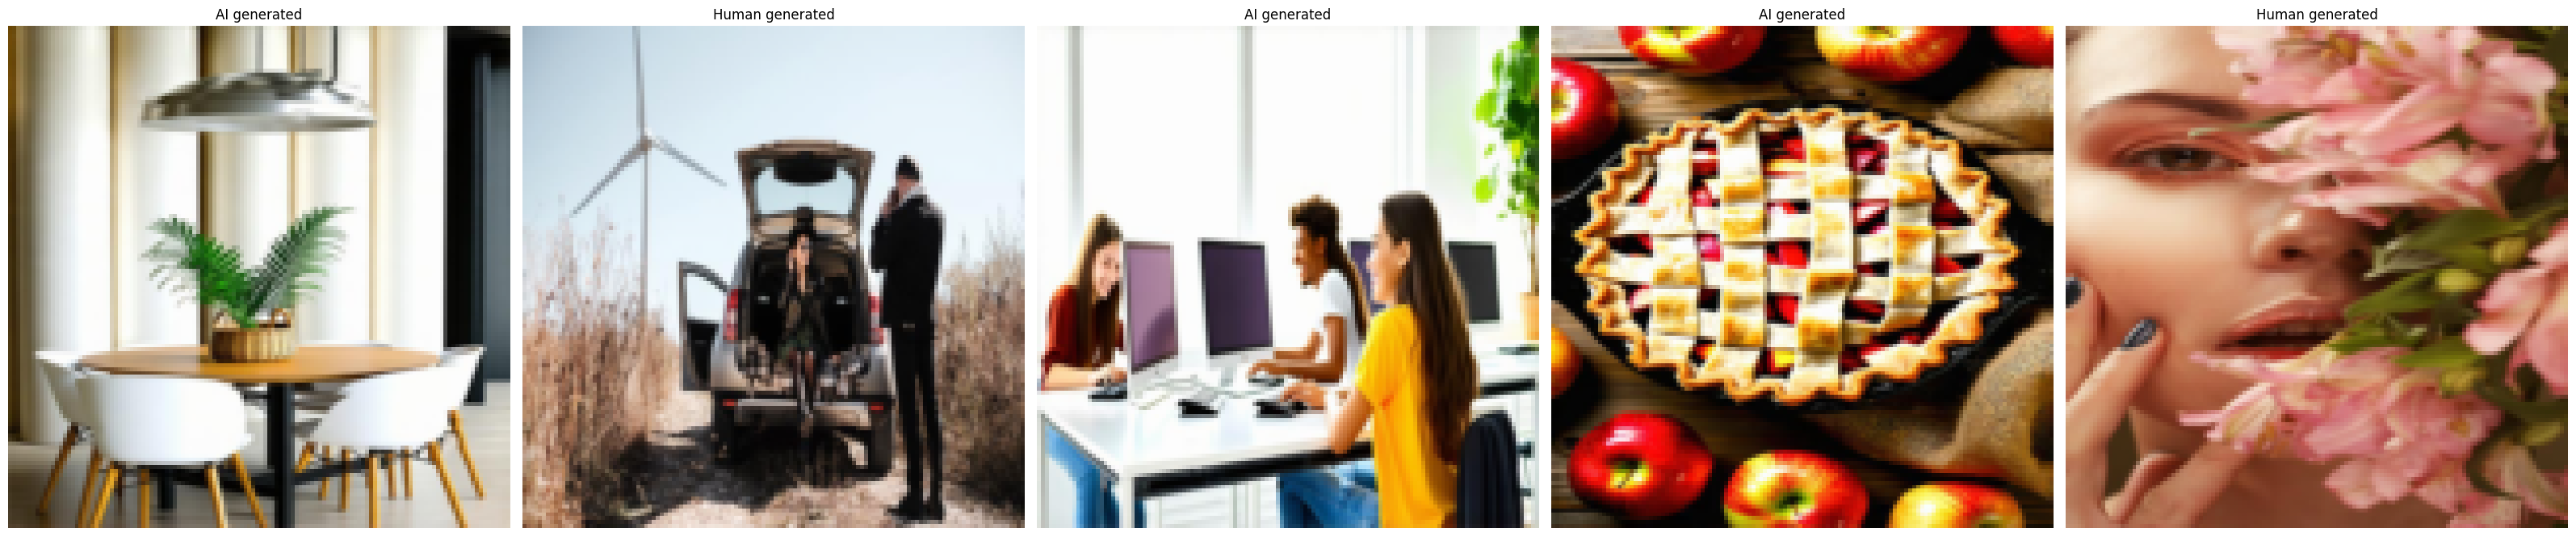

In [4]:
def show_batch(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(32, 16))
    for i in range(num_images):
        img, label = dataset[i]


        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy() 

        img = (img - img.min()) / (img.max() - img.min())
        axes[i].imshow(img)
        axes[i].set_title(labels_map[label])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(trainset)

#### Training Hybrid Classifier model

In [ ]:
# NOTE: Uncomment the below code to test your model working on a smaller subset

# trainset_size = len(trainset)
# indices = random.sample(range(trainset_size), 1000)
# trainset = torch.utils.data.dataset.Subset(trainset, indices)

In [90]:
model_factory = ModelFactory()
trainer = ModelTrainer(config, model_factory)

In [ ]:
%load_ext autoreload
%autoreload 2

model_factory = ModelFactory()
trainer = ModelTrainer(config, model_factory)

# Perform hyperparameter tuning
best_params, best_score, final_model = trainer.train_and_tune(trainset)

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")
# save_model(best_params, best_score, final_model, 'hybrid_classifier')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Skipping hyperparameter tuning and using default parameters.
Training hybrid_classifier with default parameters
Performing KFold Cross Validation with 3 folds
Epoch 1


Training: 100%|██████████| 1166/1166 [08:28<00:00,  2.29it/s, loss=0.284, acc=87.9]


Epoch 2


Training: 100%|██████████| 1166/1166 [08:42<00:00,  2.23it/s, loss=0.194, acc=92.3]


Epoch 3


Training: 100%|██████████| 1166/1166 [09:28<00:00,  2.05it/s, loss=0.133, acc=95]  


Accuracy obtained on Fold 1: 0.9561511659072635
Epoch 1


Training: 100%|██████████| 1166/1166 [09:15<00:00,  2.10it/s, loss=0.106, acc=96.1]


Epoch 2


Training: 100%|██████████| 1166/1166 [09:06<00:00,  2.13it/s, loss=0.0697, acc=97.5]


Epoch 3


Training: 100%|██████████| 1166/1166 [09:10<00:00,  2.12it/s, loss=0.0546, acc=98.2]


Accuracy obtained on Fold 2: 0.9762530152774055
Epoch 1


Training: 100%|██████████| 1166/1166 [09:00<00:00,  2.16it/s, loss=0.0647, acc=97.7]


Epoch 2


Training: 100%|██████████| 1166/1166 [09:02<00:00,  2.15it/s, loss=0.0398, acc=98.7]


Epoch 3


Training: 100%|██████████| 1166/1166 [08:59<00:00,  2.16it/s, loss=0.0324, acc=98.9]


Accuracy obtained on Fold 3: 0.9911551862771375
Mean score obtained from KFold: 0.9745197891539356
Best parameters: {}
Best score: 0.9745197891539356
Model saved to trained_models/hybrid_classifier.pt


#### Visualizing model performance

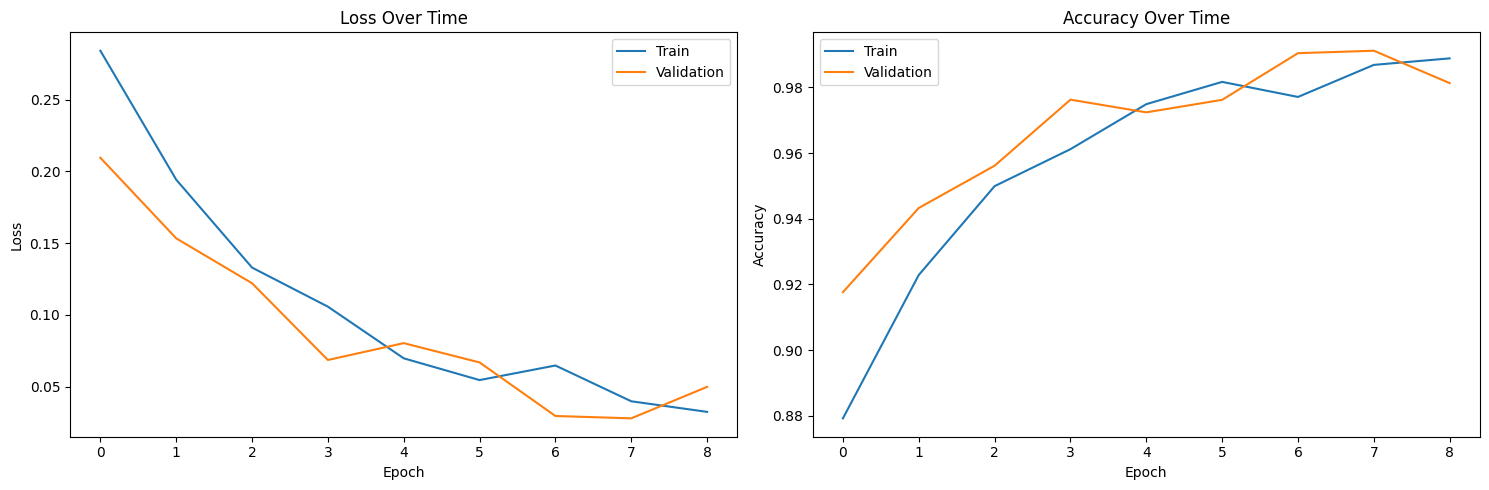

In [75]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_loss'], label='Train')
    ax1.plot(history['val_loss'], label='Validation')
    ax1.set_title('Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(history['train_acc'], label='Train')
    ax2.plot(history['val_acc'], label='Validation')
    ax2.set_title('Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(trainer.history)

#### Saving and loading the model

In [93]:
hybrid_model, params, acc = load_model(
    HybridClassifier, 
    'trained_models/hybrid_classifier.pt'
    )
hybrid_model

Model loaded from trained_models/hybrid_classifier.pt, with score: 0.9745197891539356


/Users/prashanthjaganathan/Desktop/CS6140 - ML/GeneratedImageDetector/human-ai-image-detection/src/utils/model_utils.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  che

HybridClassifier(
  (cnn_branch): CNNBranch(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (attention): SpatialAttention(
      (conv): Conv2d(64, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    )
    (fc): Linear(in_features=65536, out_features=50, bias=True)
  )
  (handcrafted_branch): HandcraftedBranch(
    (fc1): Linear(in_features=9, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=50, bias=True)
  )
  (fc_fusion): Linear(in_features=100, out_features=64, bias=True)
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)

In [94]:
valloader = torch.utils.data.DataLoader(valset)
val_loss, val_acc = trainer._evaluate(hybrid_model, valloader)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

Validation Loss: 0.057386645630227454
Validation Accuracy: 0.980279341254951


### Loading trained model for random testing

/Users/prashanthjaganathan/Desktop/CS6140 - ML/GeneratedImageDetector/src/training/trainer.py:375: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(mode

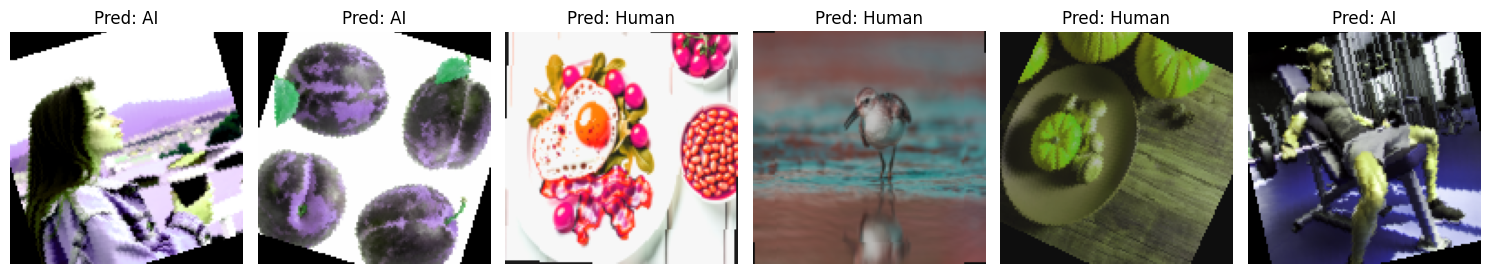

In [ ]:
model_factory = ModelFactory()
model_name = 'hybrid_classifier'

base_params = config['models'][model_name].get('base_params') or {}  # Fallback to empty dict if None
model = model_factory.get_model(model_name, **base_params)
model_path = f"trained_models/{model_name}.pt"

ModelTrainer.test_random(
    # modifies the images with color jitters, cropping, etc
    model_path=model_path,
    model=model,
    num_images=6,
    csv_path="dataset/test.csv"
)